In [1]:
from collections import Counter
import os
import random
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
import torch

In [4]:
seed_value = 10

def define_seed(seed_value):
    # Set a seed value
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

define_seed(seed_value)

In [5]:
def get_manual_semantic_set_data(semantic_set_ids_manual):
    #Receives a semantic_set_ids_manual and returns a list of integers (that represent the cluster)
    #e.g. ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6',
    # 'Cluster 7', 'Cluster 8', 'Cluster 9'] -> [0,1,2,3,4,5,6,7,8,9]
    semantic_set_ids_manual_list = [int(cluster.replace('Cluster ','')) for cluster in semantic_set_ids_manual]
    return semantic_set_ids_manual_list

def get_estimator(sequences):
    seq_counter = dict(Counter(sequences))
    dist_support = seq_counter.keys()
    counts = list(seq_counter.values())
    dist_probs = [count/sum(counts) for count in counts]

    return dist_support, torch.tensor(dist_probs)

def entropy(probs):
    log_probs = torch.log(probs)
    entropy = - torch.sum(torch.mul(probs, log_probs))

    return entropy

def align_semantics_sets_with_dist(sentences, semantic_sets, dist_support):
    #Recovers which semantic set each item in the distribution support belongs to
    #Reutrns a list of cluster_ids (aligned with dist_support)
    dist_semantic_sets = []
    for sentence in dist_support:
        index = sentences.index(sentence)
        dist_semantic_sets.append(semantic_sets[index])#.item())

    return dist_semantic_sets

def semantic_entropy(probs, semantic_sets):
    #Adds the probs of elements of the support belonging to the same semantic set to find the probability of
    #each cluster, and then computes semantic entropy
    classes = set(semantic_sets)
    probs_classes = []
    for c in classes:
        probs_items_in_class = torch.where((torch.LongTensor(semantic_sets) == c), probs, torch.zeros(len(probs)))
        prob_class = torch.sum(probs_items_in_class)
        probs_classes.append(prob_class.item())

    sem_entropy = entropy(torch.tensor(probs_classes))
    # return classes, probs_classes, sem_entropy
    return classes, probs_classes, sem_entropy


In [6]:
#Classification labels for correctness ['String matches (fully) one of correct/valid answers', 'String (partly) includes one correct/valid answers',
# 'String includes multiple (but not all) correct/valid answers', 'String includes all correct/valid answers', 'Wrong', 'String expresses inability to answer']
def add_manual_sem_ent(sequences):
    for sample in sequences:
        id_ = sample['id']

        generations = sample['cleaned_text']

        dist_support, dist_probs = get_estimator(generations)

        semantic_set_ids_manual = get_manual_semantic_set_data(sample['semantic_set_ids_manual'])
        dist_semantic_sets = align_semantics_sets_with_dist(generations, semantic_set_ids_manual, dist_support)
        classes, probs_classes, semantic_entropy_value = semantic_entropy(dist_probs, dist_semantic_sets)

        if (sample['greedy_correct_manual'] == 'Wrong') or (sample['greedy_correct_manual'] == 'String expresses inability to answer'):
          greedy_correct_manual_binary = 0
        # elif sample['greedy_correct_manual'] == 'String expresses inability to answer':
        #   greedy_correct_manual_binary = 1
        else:
          greedy_correct_manual_binary = 1

        sample['semantic_entropy_manual'] = semantic_entropy_value.item()
        sample['greedy_correct_manual_binary'] = greedy_correct_manual_binary
        sample['semantic_dist'] = (classes, probs_classes)

    return sequences

In [25]:
def get_relevant_info(data, analysis = 'manual_annotations'):
    try: #in case this version of info is not available
        sem_ent_entail = [item['semantic_entropy_entail'] for item in data]
    except:
        sem_ent_entail = []

    try:
        pred_ent = [item['entropy'] for item in data]
    except:
        generations = [item['cleaned_text'] for item in data]
        distributions = [(get_estimator(item)) for item in generations]
        pred_ent = [entropy(item[1]) for item in distributions]
    try:
        correctness = [item['greedy_correct'] for item in data]
    except:
        correctness = []
    if analysis == 'manual_annotations':
        try:
            sem_ent_manual = [item['semantic_entropy_manual'] for item in data]
        except:
            sem_ent_manual = []
        correctness_manual = [item['greedy_correct_manual_binary'] for item in data]
    else:
        sem_ent_manual = []
        correctness_manual = []

    return sem_ent_entail, pred_ent, correctness, sem_ent_manual, correctness_manual

In [8]:
def get_dist_support_num(data):
    try:
        dist_support_num = [len(item['generations_dist_support']) for item in data]
    except:
        generations = [item['cleaned_text'] for item in data]
        distributions = [(get_estimator(item)) for item in generations]
        dist_support_num = [len(item[0]) for item in distributions]
    return dist_support_num

In [9]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

## Correlating correctness of greedy to correctness of individual answers

In [10]:
def add_manual_correctness(sequences):
    for sample in sequences:
        if (sample['greedy_correct_manual'] == 'Wrong') or (sample['greedy_correct_manual'] == 'String expresses inability to answer'):
            greedy_correct_manual_binary = 0
        # elif sample['greedy_correct_manual'] == 'String expresses inability to answer':
        #     greedy_correct_manual_binary = 1
        else: #correct
            greedy_correct_manual_binary = 1

        sample['greedy_correct_manual_binary'] = greedy_correct_manual_binary

        correctness_samples_manual_binary = []
        for item in sample['correctness_samples_manual']:
            if (item =='Wrong') or (item == 'Inability to answer'):
                correctness_samples_manual_binary.append(0)
            # elif (item == 'Inability to answer'):
            #     correctness_samples_manual_binary.append(1)
            else: #correct
                correctness_samples_manual_binary.append(1)
        sample['correctness_samples_manual_binary'] = correctness_samples_manual_binary

    return sequences

In [11]:
def get_correctness_info(data):
    correct_samples = [item['correctness_samples_manual_binary'] for item in data]
    correctness = [item['greedy_correct_manual_binary'] for item in data]

    return correct_samples, correctness

In [12]:
def run_sequences(path, analysis = 'manual_annotations'):
    with open(path) as f:
        sequences = json.load(f)

    if analysis == 'manual_annotations':
        sequences = add_manual_correctness(sequences)
        correct_samples_manual, correctness_manual = get_correctness_info(sequences)
    else:
        #in the case of automatic annotations
        correct_samples_manual = ['N/A']
        correctness_manual = ['N/A']

    return sequences, correct_samples_manual, correctness_manual

In [13]:
def check_performance_for_adequacy_classifier(correct_samples_manual, correct_proxy):
    flatten_correct_samples_manual = [i for x in correct_samples_manual for i in x]
    flatten_correct_proxy = [i for x in correct_proxy for i in x]

    flatten_correct_samples_manual_clean = [flatten_correct_samples_manual[i] for i in range(len(flatten_correct_samples_manual)) if flatten_correct_proxy[i] != 'Not defined']
    flatten_correct_proxy = [flatten_correct_proxy[i] for i in range(len(flatten_correct_samples_manual)) if flatten_correct_proxy[i] != 'Not defined']

    recall = recall_score(flatten_correct_samples_manual_clean, flatten_correct_proxy)
    precision = precision_score(flatten_correct_samples_manual_clean, flatten_correct_proxy)
    accuracy = accuracy_score(flatten_correct_samples_manual_clean, flatten_correct_proxy)
    f1 = f1_score(flatten_correct_samples_manual_clean, flatten_correct_proxy)
    conf = confusion_matrix(flatten_correct_samples_manual_clean, flatten_correct_proxy)

    return recall, precision, accuracy, f1, conf

In [14]:
def nli_adeq_manual_info(sequences, stored_info, llm_based = 'True'):
    #NLI
    predicted_support = [item[stored_info] for item in sequences]

    if llm_based == 'False':
        #We assess whether p_entail > p_neutral + p_contra --> if that holds then we make a positive decision - the generation is adequate
        probs_support = []
        correct_support = []
        for gens in predicted_support:
            probs_support_per_context = []
            correct_support_per_context = []
            for item in gens:
                try:
                    position_support = [list(item[1].values()).index('ENTAILMENT')][0]
                except:
                    position_support = [list(item[1].values()).index('entailment')][0]
                prob_support = item[0][int(position_support)]
                prob_not_support = 1 - prob_support #i.e. prob_contra + prob_entailment
                probs_support_per_context.append(prob_support)
                if prob_support > prob_not_support:
                    pred = 1
                else:
                    pred = 0
                correct_support_per_context.append(pred)

            probs_support.append(probs_support_per_context)
            correct_support.append(correct_support_per_context)
    else:
        correct_support = []
        for gens in predicted_support:
            c_entail = []
            for gen in gens:
                if ('entail' in gen.lower()):
                    c_entail.append(1)
                else:
                    c_entail.append(0)

            correct_support.append(c_entail)
        probs_support = 'N/A'
            # semantic_set_ids.append(sem_sets)

    return probs_support, correct_support

In [15]:
def fact_check_manual_info(sequences, stored_info):
    #Fact check
    predicted_support = [item[stored_info] for item in sequences]
    # semantic_set_ids = []
    correct_fact_check_proxy = []
    sum_na = 0
    for gens in predicted_support:
        c_fact_check = []
        for gen in gens:
            if ('true' in gen.lower()) and ('false' in gen.lower()):
                sum_na += 1
                c_fact_check.append('Not defined')
            elif ('false' in gen.lower()):
                c_fact_check.append(0)
            # elif (gen[:5].lower() == ' true') or
            elif ('true' in gen.lower()):
                c_fact_check.append(1)
            else:
                sum_na += 1
                c_fact_check.append('Not defined')

        correct_fact_check_proxy.append(c_fact_check)

    return correct_fact_check_proxy

In [16]:
def normalise_pred_ent(pred_ent, dist_support_num):
    norm_pred_ent = [1 - pred_ent[i]/np.log(dist_support_num[i]) if dist_support_num[i] != 1 else 1 for i in range(len(pred_ent))]
    return norm_pred_ent

In [17]:
def normalise_sem_ent(sem_ent, num_clusters):
    norm_sem_ent = [1 - sem_ent[i]/np.log(num_clusters[i]) if num_clusters[i] != 1 else 1 for i in range(len(pred_ent))] #if there is only 1 cluster we are fully confident in it -> hence, norm_sem_ent = 1
    return norm_sem_ent

In [18]:
def compute_probar(correct_fact_check_proxy):
    correct_fact_check_proxy_clean = [list(filter(lambda a: a != 'Not defined', item)) for item in correct_fact_check_proxy]
    # sum_correct = [sum(item) for item in correct_fact_check_proxy_clean]
    probar = [sum(correct_fact_check_proxy_clean[i])/len(correct_fact_check_proxy_clean[i]) for i in range(len(correct_fact_check_proxy_clean))]

    return probar

In [19]:
def selective_generation(conf_score, correctness):
    selective_performance = []
    thresholds = []
    coverage = []
    for t in range(math.floor(max(conf_score)*100)):
        threshold = t/100
        selective_predicted_correctness = [correctness[i] for i in range(len(correctness)) if conf_score[i] >= threshold]
        items_predicted = len(selective_predicted_correctness)
        accuracy = len([x for x in selective_predicted_correctness if x == True])/items_predicted
        selective_performance.append(accuracy)
        thresholds.append(threshold)
        coverage.append(items_predicted/len(correctness))

    return selective_performance, thresholds, coverage

In [20]:
def get_random_sample_from_list(l,n_samples):
    """Receive a list and randomly sample a number of samples from them (using sampling without replacement)"""
    return random.sample(l, n_samples)

In [21]:
def fact_check_auto_correct_llm_as_judge(sequences, stored_info):
    #Fact check
    predicted_support = [item[stored_info] for item in sequences]
    correct_fact_check_proxy = []
    sum_na = 0
    for gens in predicted_support:
        if ('true' in gens.lower()) and ('false' in gens.lower()):
            sum_na += 1
            correct_fact_check_proxy.append('Not defined')
        elif ('false' in gens.lower()):
            correct_fact_check_proxy.append(0)
        elif ('true' in gens.lower()):
            correct_fact_check_proxy.append(1)
        else:
            sum_na += 1
            correct_fact_check_proxy.append('Not defined')
    return correct_fact_check_proxy


# Results on the total set

In [50]:
# path_name = '/probar/generations/AmbigQA/sequencesopt-2.7b_ambig_qa.json'
# path_name = '/probar/generations/AmbigQA/sequencesopt-6.7b_ambig_qa.json'
# path_name = '/probar/generations/AmbigQA/sequencesopt-13b_ambigqa.json'
path_name = '/probar/generations/AmbigQA/sequencesopt-30b_ambig_qa.json'

sequences, correct_samples_manual, correctness_manual = run_sequences(path_name, 'automatic_annotations')

In [51]:
sem_ent_entail, pred_ent, correctness, sem_ent_manual, correctness_manual = get_relevant_info(sequences, 'automatic_annotations')
norm_sem_ent_entail = normalise_sem_ent(sem_ent_entail, [len(set(item['semantic_set_ids_entail'])) for item in sequences])
prob_true = [np.exp(item['log_prob_true']) for item in sequences]
greedy_correct_llm_as_a_judge = fact_check_auto_correct_llm_as_judge(sequences, 'greedy_plausible_gpt-3.5-turbo_classifier')

In [52]:
dist_support_num = get_dist_support_num(sequences)
norm_pred_ent = normalise_pred_ent(pred_ent, dist_support_num)
probar = [item['probar'] for item in sequences]

In [53]:
correctness = greedy_correct_llm_as_a_judge.copy() #llm as judge for greedy correctness
# correctness = [x['greedy_correct'] for x in sequences] #rougeL criterion for greedy correctness

In [54]:
selective_performance_probar, thresholds_probar, coverage_probar = selective_generation(probar, correctness)
selective_performance_norm_pred_ent, thresholds_norm_pred_ent, coverage_norm_pred_ent = selective_generation(norm_pred_ent, correctness)
selective_performance_norm_sem_ent_entail, thresholds_norm_sem_ent_entail, coverage_norm_sem_ent_entail = selective_generation(norm_sem_ent_entail, correctness)
selective_performance_prob_true, thresholds_prob_true, coverage_prob_true = selective_generation(prob_true, correctness)

# OPT2.7B

In [31]:
proxy_probar_auroc_opt2_7 = roc_auc_score(correctness, probar)
entail_norm_sem_ent_auroc_opt2_7 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt2_7 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt2_7 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt2_7 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt2_7 = roc_auc_score(correctness, prob_true)

proxy probar 0.6497557382133996
norm_sem_ent_entail 0.4214872828784119
sem_ent_entail 0.42016904466501237
norm_pred_ent 0.4042661807278743
pred_ent 0.4032710401157982
prob_true 0.4893636269644335


Text(0.5, 1.0, 'OPT-2.7B Receiver Operator Characteristic Curve')

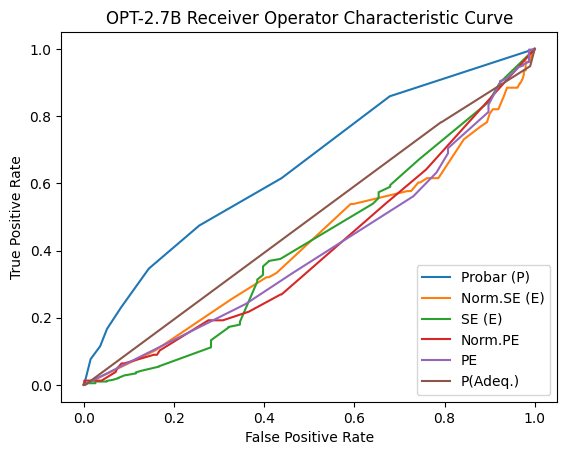

In [32]:
print('proxy probar',proxy_probar_auroc_opt2_7)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt2_7)
print('sem_ent_entail',entail_sem_ent_auroc_opt2_7)
print('norm_pred_ent',norm_pred_ent_auroc_opt2_7)
print('pred_ent',pred_ent_auroc_opt2_7)
print('prob_true',prob_true_auroc_opt2_7)

plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (P)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-2.7B Receiver Operator Characteristic Curve')

Text(0.5, 1.0, 'OPT-2.7B')

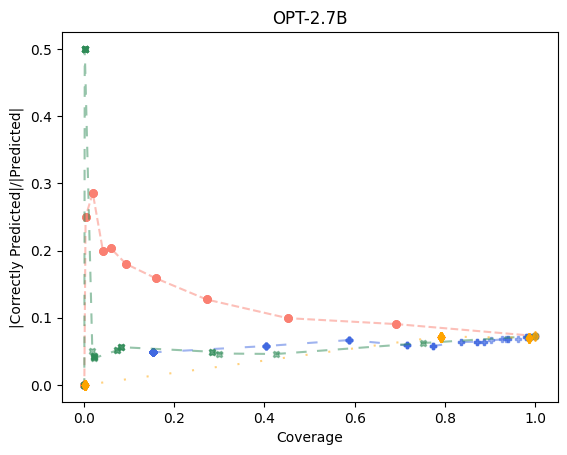

In [33]:
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 10)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.PE', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0,(1,10)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-2.7B")

# OPT-6.7B

In [39]:
proxy_probar_auroc_opt6_7 = roc_auc_score(correctness, probar)
entail_norm_sem_ent_auroc_opt6_7 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt6_7 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt6_7 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt6_7 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt6_7 = roc_auc_score(correctness, prob_true)

proxy probar 0.5952876491053678
norm_sem_ent_entail 0.4775177062624254
sem_ent_entail 0.48252671471172964
norm_pred_ent 0.41831821570576544
pred_ent 0.4189550198807157
prob_true 0.500069893141153


Text(0.5, 1.0, 'OPT-6.7B Receiver Operator Characteristic Curve')

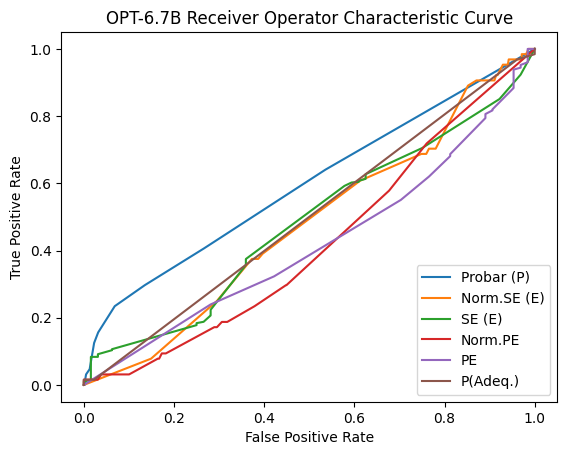

In [40]:
print('proxy probar',proxy_probar_auroc_opt6_7)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt6_7)
print('sem_ent_entail',entail_sem_ent_auroc_opt6_7)
print('norm_pred_ent',norm_pred_ent_auroc_opt6_7)
print('pred_ent',pred_ent_auroc_opt6_7)
print('prob_true',prob_true_auroc_opt6_7)

plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (P)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-6.7B Receiver Operator Characteristic Curve')

Text(0.5, 1.0, 'OPT-6.7B')

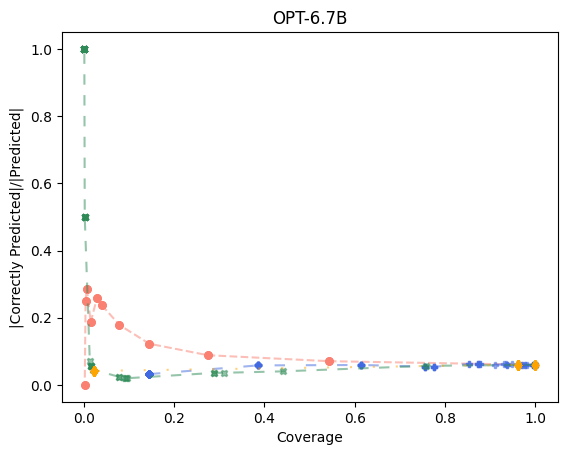

In [41]:
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 10)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.PE', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0,(1,10)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-6.7B")

# OPT13B

In [47]:
proxy_probar_auroc_opt13 = roc_auc_score(correctness, probar)
entail_norm_sem_ent_auroc_opt13 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt13 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt13 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt13 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt13 = roc_auc_score(correctness, prob_true)

proxy probar 0.5330050944333996
norm_sem_ent_entail 0.5589276838966203
sem_ent_entail 0.5558135561630219
norm_pred_ent 0.42149447067594437
pred_ent 0.4187298086481113
prob_true 0.5016463717693836


Text(0.5, 1.0, 'OPT-13B Receiver Operator Characteristic Curve')

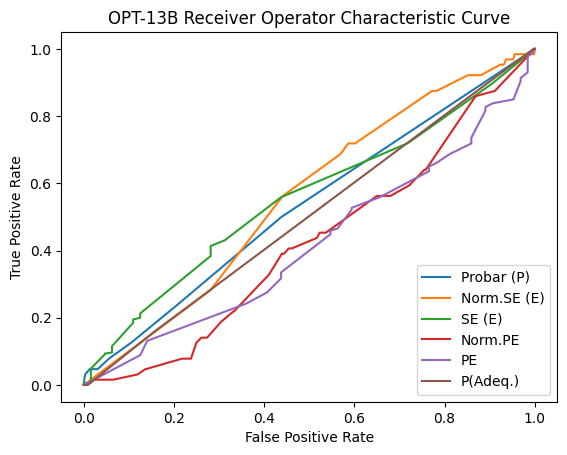

In [48]:
print('proxy probar',proxy_probar_auroc_opt13)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt13)
print('sem_ent_entail',entail_sem_ent_auroc_opt13)
print('norm_pred_ent',norm_pred_ent_auroc_opt13)
print('pred_ent',pred_ent_auroc_opt13)
print('prob_true',prob_true_auroc_opt13)

plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (P)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-13B Receiver Operator Characteristic Curve')


Text(0.5, 1.0, 'OPT-13B')

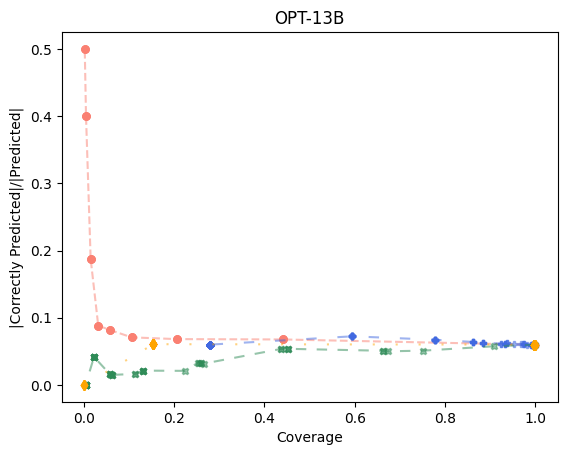

In [49]:
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 10)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.PE', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0,(1,10)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-13B")

# OPT30B

In [55]:
proxy_probar_auroc_opt30 = roc_auc_score(correctness, probar)
entail_norm_sem_ent_auroc_opt30 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt30 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt30 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt30 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt30 = roc_auc_score(correctness, prob_true)

proxy probar 0.5973161453930685
norm_sem_ent_entail 0.5250598760214145
sem_ent_entail 0.5256234150464919
norm_pred_ent 0.4788760918568611
pred_ent 0.47885848126232744
prob_true 0.5335305719921105


Text(0.5, 1.0, 'OPT-30B Receiver Operator Characteristic Curve')

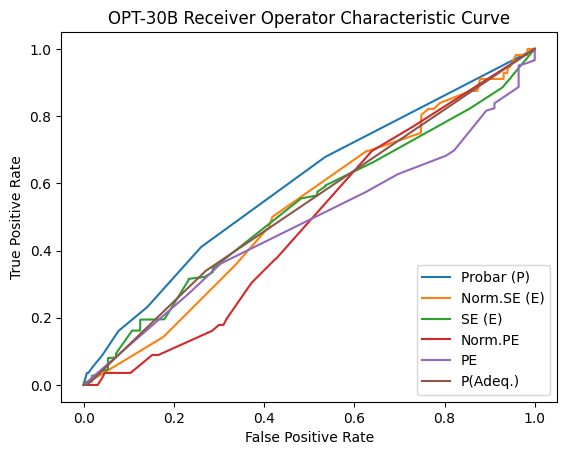

In [56]:
print('proxy probar',proxy_probar_auroc_opt30)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt30)
print('sem_ent_entail',entail_sem_ent_auroc_opt30)
print('norm_pred_ent',norm_pred_ent_auroc_opt30)
print('pred_ent',pred_ent_auroc_opt30)
print('prob_true',prob_true_auroc_opt30)

plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (P)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-30B Receiver Operator Characteristic Curve')

Text(0.5, 1.0, 'OPT-30B')

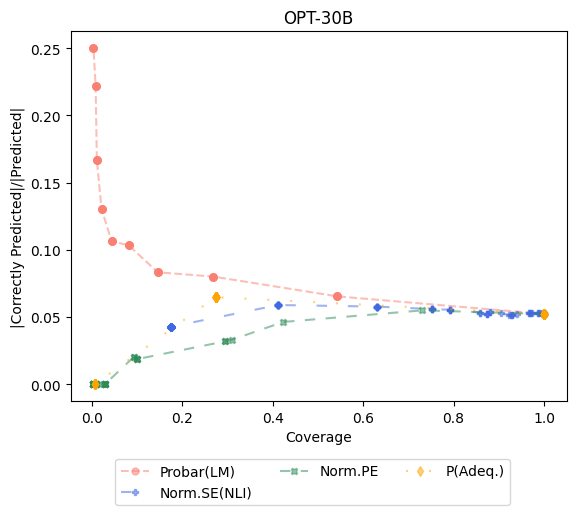

In [57]:
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 10)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.PE', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0,(1,10)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

plt.legend(loc='lower right', ncol=3, bbox_to_anchor=(0.9, -0.3))
plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-30B")